<h4> Import Data</h4>

In [8]:
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

<h4> Build the neural network</h4>

In [9]:

model = Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(100, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

<h4>Image Data Generation/Augmentation</h4>

In [10]:

TRAINING_DIR = "data training"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=20, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "data validation"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=20, 
                                                         target_size=(150, 150))

Found 3080 images belonging to 2 classes.
Found 782 images belonging to 2 classes.


<h4> Initialize a callback checkpoint to keep saving best model after each epoch while training </h4>

In [11]:
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=False,mode='auto')

<h4> Train the model </h4>

In [12]:
history = model.fit(train_generator,
                              epochs=5,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

Epoch 1/5
154/154 [==============================] - ETA: 0s - loss: 0.4757 - acc: 0.7688

INFO:tensorflow:Assets written to: model2-001.model\assets


INFO:tensorflow:Assets written to: model2-001.model\assets


154/154 [==============================] - 231s 1s/step - loss: 0.4757 - acc: 0.7688 - val_loss: 0.2421 - val_acc: 0.9156
Epoch 2/5
154/154 [==============================] - ETA: 0s - loss: 0.3777 - acc: 0.8487

INFO:tensorflow:Assets written to: model2-002.model\assets


INFO:tensorflow:Assets written to: model2-002.model\assets


154/154 [==============================] - 226s 1s/step - loss: 0.3777 - acc: 0.8487 - val_loss: 0.1681 - val_acc: 0.9450
Epoch 3/5
154/154 [==============================] - ETA: 0s - loss: 0.3352 - acc: 0.8649

INFO:tensorflow:Assets written to: model2-003.model\assets


INFO:tensorflow:Assets written to: model2-003.model\assets


154/154 [==============================] - 230s 1s/step - loss: 0.3352 - acc: 0.8649 - val_loss: 0.1490 - val_acc: 0.9476
Epoch 4/5
154/154 [==============================] - ETA: 0s - loss: 0.3117 - acc: 0.8760

INFO:tensorflow:Assets written to: model2-004.model\assets


INFO:tensorflow:Assets written to: model2-004.model\assets


154/154 [==============================] - 228s 1s/step - loss: 0.3117 - acc: 0.8760 - val_loss: 0.1793 - val_acc: 0.9425
Epoch 5/5
154/154 [==============================] - ETA: 0s - loss: 0.3020 - acc: 0.8838

INFO:tensorflow:Assets written to: model2-005.model\assets


INFO:tensorflow:Assets written to: model2-005.model\assets


154/154 [==============================] - 228s 1s/step - loss: 0.3020 - acc: 0.8838 - val_loss: 0.1583 - val_acc: 0.9348


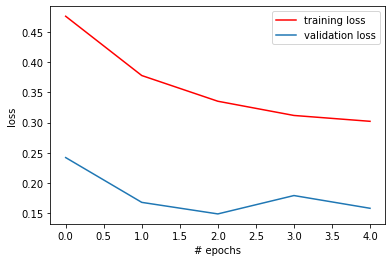

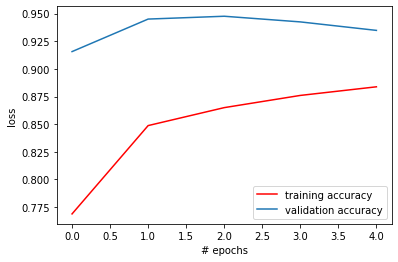

In [13]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history.history['acc'],'r',label='training accuracy')
plt.plot(history.history['val_acc'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [14]:
import cv2
import numpy as np
from keras.models import load_model
model=load_model("model2-004.model")

results={0:'Tanpa masker',1:'Menggunakan masker'}
GR_dict={0:(0,0,255),1:(0,255,0)}

rect_size = 4
cap = cv2.VideoCapture(0) 


haarcascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 

    
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = haarcascade.detectMultiScale(rerect_size)
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
        
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150,150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)



        
        label=np.argmax(result,axis=1)[0]
      
    
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    
    if key == 27: 
        break

cap.release()

cv2.destroyAllWindows()

1/1 [==============================] - 0s 48ms/step
